# Ponniyin Selvan Embeddings Evaluation

In this notebook, we evaluate the quality of two types of embeddings, CBOW (Continuous Bag of Words) and RNN-based embeddings, derived from the **Ponniyin Selvan** text. We perform intrinsic and extrinsic evaluations to understand their effectiveness in representing the semantic meaning of words and phrases.
    

In [1]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import load_model
from keras.layers import BatchNormalization
from keras.utils import get_custom_objects
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

## Load CBOW and RNN Embeddings

We load the CBOW embeddings from a pre-trained text file and the RNN embeddings from a saved Keras model. Both embeddings will be used for evaluation purposes.
    

In [2]:
# Load CBOW Embeddings from .txt file
cbow_embeddings = {}
cbow_embedding_path = 'embedding/my_cbow_vectors_ps.txt'  # Update with your path

with open(cbow_embedding_path, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    try:
        vocab_size, embedding_dim = map(int, first_line.strip().split())
    except ValueError:
        f.seek(0)
        lines = f.readlines()
        vocab_size = len(lines)
        first_vector = lines[0].strip().split()
        embedding_dim = len(first_vector) - 1
        f.seek(0)
    
    for line in f:
        values = line.strip().split()
        if len(values) < embedding_dim + 1:
            continue
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        cbow_embeddings[word] = vector

print(f"Loaded CBOW Embeddings: {len(cbow_embeddings)} words with dimension {embedding_dim}")

# Load RNN model and extract embeddings
rnn_model_path = 'model/rnn_direct_model.h5'  # Update with your path
get_custom_objects().update({'BatchNormalization': BatchNormalization})
rnn_model = load_model(rnn_model_path, custom_objects={'BatchNormalization': BatchNormalization})
try:
    rnn_embedding_layer = rnn_model.get_layer('embedding_layer')
except ValueError:
    print("Available layers in RNN model:")
    for layer in rnn_model.layers:
        print(layer.name)
    raise

rnn_embeddings = rnn_embedding_layer.get_weights()[0]
print(f"Loaded RNN Embeddings: {rnn_embeddings.shape[0]} words with dimension {rnn_embeddings.shape[1]}")

# Load RNN model and extract embeddings
dnn_model_path = 'model/dnn_model.h5'  # Update with your path
dnn_model = load_model(dnn_model_path)
try:
    dnn_embedding_layer = dnn_model.get_layer('embedding_layer')
except ValueError:
    print("Available layers in RNN model:")
    for layer in dnn_model.layers:
        print(layer.name)
    raise

dnn_embeddings = dnn_embedding_layer.get_weights()[0]
print(f"Loaded DNN Embeddings: {dnn_embeddings.shape[0]} words with dimension {dnn_embeddings.shape[1]}")

Loaded CBOW Embeddings: 69350 words with dimension 100
Loaded RNN Embeddings: 16137 words with dimension 100
Loaded DNN Embeddings: 16137 words with dimension 100


## Load Pre-Processed Data

Next, we load the tokenized sentences and the word-to-index mappings that will help us perform evaluations on the embeddings.
    

In [3]:
# Load pre-processed data
tokenized_sentences_path = 'pickle/tokenized_sentences_ps.pkl'
word_to_index_path = 'pickle/word_to_index_ps.pkl'
index_to_word_path = 'pickle/index_to_word_ps.pkl'

with open(tokenized_sentences_path, 'rb') as f:
    tokenized_sentences = pickle.load(f)
with open(word_to_index_path, 'rb') as f:
    word_to_index = pickle.load(f)
with open(index_to_word_path, 'rb') as f:
    index_to_word = pickle.load(f)

vocab_size_loaded = len(word_to_index)
print(f"Vocabulary Size: {vocab_size_loaded}")

Vocabulary Size: 16137


## Helper Functions

We define helper functions for vector retrieval, normalization, and calculating sentence vectors.
    

In [4]:
def get_vector(word, embeddings, is_cbow=True):
    if is_cbow:
        return embeddings.get(word, np.zeros(len(next(iter(embeddings.values())))))
    else:
        idx = word_to_index.get(word, 0)
        if idx < embeddings.shape[0]:
            return embeddings[idx]
        else:
            return np.zeros(embeddings.shape[1])

def normalize_embeddings(embeddings, is_cbow=True):
    if is_cbow:
        for word in embeddings:
            norm = np.linalg.norm(embeddings[word])
            if norm != 0:
                embeddings[word] /= norm
        return embeddings
    else:
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        norms[norms == 0] = 1
        embeddings = embeddings / norms
        return embeddings

def sentence_vector(sentence, embeddings, is_cbow=True):
    vectors = [get_vector(word, embeddings, is_cbow) for word in sentence if word in word_to_index]
    if not vectors:
        return np.zeros(embeddings.shape[1] if not is_cbow else len(next(iter(embeddings.values()))))
    return np.mean(vectors, axis=0)

## Normalize the Embeddings

Normalization ensures that all vectors have a unit length, which helps in more stable and comparable similarity computations.
    

In [5]:
cbow_embeddings = normalize_embeddings(cbow_embeddings, is_cbow=True)
rnn_embeddings = normalize_embeddings(rnn_embeddings, is_cbow=False)
dnn_embeddings = normalize_embeddings(dnn_embeddings, is_cbow=False)

## Intrinsic Evaluation 
### 1. Word Similarity

We calculate the cosine similarity between pairs of related words to see how well each embedding captures semantic relationships.
    

In [6]:
print("=== Word Similarity Evaluation ===\n")
word_pairs = [
    ('சோழர்', 'பாண்டியர்'),      # Cholas - Pandyas
    ('அரசர்', 'அரசி'),          # King - Queen
    ('குதிரை', 'யானை'),         # Horse - Elephant
    ('படை', 'போர்'),             # Army - War
    ('வீரன்', 'போராளி'),         # Warrior - Fighter
    ('நட்பு', 'தோழமை'),         # Friendship - Camaraderie
    ('அரண்மனை', 'அரசு'),        # Palace - Kingdom
    ('அழகு', 'அரசியல்'),         # Beauty - Politics
    ('தீர்மானம்', 'விவாதம்'),    # Decision - Debate
]

for word1, word2 in word_pairs:
    sim_cbow = cosine_similarity(
        [get_vector(word1, cbow_embeddings, is_cbow=True)],
        [get_vector(word2, cbow_embeddings, is_cbow=True)]
    )[0][0]
    sim_rnn = cosine_similarity(
        [get_vector(word1, rnn_embeddings, is_cbow=False)],
        [get_vector(word2, rnn_embeddings, is_cbow=False)]
    )[0][0]
    sim_dnn = cosine_similarity(
        [get_vector(word1, dnn_embeddings, is_cbow=False)],
        [get_vector(word2, dnn_embeddings, is_cbow=False)]
    )[0][0]
    print(f"Word Pair: {word1} - {word2}")
    print(f"CBOW Similarity: {sim_cbow:.4f}")
    print(f"RNN Similarity: {sim_rnn:.4f}")
    print(f"DNN Similarity: {sim_dnn:.4f}\n")

=== Word Similarity Evaluation ===

Word Pair: சோழர் - பாண்டியர்
CBOW Similarity: 0.1569
RNN Similarity: 0.0229
DNN Similarity: 0.0714

Word Pair: அரசர் - அரசி
CBOW Similarity: 0.0631
RNN Similarity: -0.0360
DNN Similarity: 0.2083

Word Pair: குதிரை - யானை
CBOW Similarity: 0.4073
RNN Similarity: 0.3726
DNN Similarity: 0.7088

Word Pair: படை - போர்
CBOW Similarity: 0.1186
RNN Similarity: 0.1867
DNN Similarity: 0.3253

Word Pair: வீரன் - போராளி
CBOW Similarity: 0.0000
RNN Similarity: -0.0489
DNN Similarity: 0.0645

Word Pair: நட்பு - தோழமை
CBOW Similarity: -0.0134
RNN Similarity: 1.0000
DNN Similarity: 1.0000

Word Pair: அரண்மனை - அரசு
CBOW Similarity: 0.1043
RNN Similarity: -0.0634
DNN Similarity: 0.1592

Word Pair: அழகு - அரசியல்
CBOW Similarity: 0.0784
RNN Similarity: -0.0827
DNN Similarity: -0.0441

Word Pair: தீர்மானம் - விவாதம்
CBOW Similarity: -0.1460
RNN Similarity: -0.0686
DNN Similarity: 0.0082



#### Observations

- **`CBOW Embeddings`**: CBOW embeddings generally capture moderate similarity across some pairs, notably achieving a score of 0.4073 for "குதிரை" (Horse) and "யானை" (Elephant), reflecting a broad understanding of animal associations. However, in pairs like "வீரன்" (Warrior) and "போராளி" (Fighter), it scored 0.0000, which suggests CBOW’s limited effectiveness in capturing nuanced semantic relationships for these word pairs.
  
- **`RNN Embeddings`**: The RNN embeddings demonstrate an exceptionally high similarity score (1.0000) for "நட்பு" (Friendship) and "தோழமை" (Camaraderie), showcasing a strong capacity to capture closely related terms. Nonetheless, RNN embeddings show variability, with unexpected results such as -0.0360 for "அரசர்" (King) and "அரசி" (Queen), possibly reflecting sensitivity to specific narrative contexts rather than consistent semantic relationships.

- **`DNN Embeddings`**: DNN embeddings tend to show higher similarity for broader, more tangible relationships, such as 0.7088 for "குதிரை" (Horse) and "யானை" (Elephant) and 0.3253 for "படை" (Army) and "போர்" (War). However, in more abstract pairs, such as "தீர்மானம்" (Decision) and "விவாதம்" (Debate), DNN similarity is low at 0.0082, suggesting weaker performance for abstract concepts.

#### Summary

The similarity evaluation highlights the varied performance of each embedding model. CBOW embeddings, while able to capture some semantic associations, tend to produce lower or less relevant similarity scores for many pairs. RNN embeddings, despite some variability, demonstrate strong relational understanding for pairs with close contextual links, such as "Friendship" and "Camaraderie." DNN embeddings, while strong in capturing tangible relationships, show limitations with abstract terms, which underscores RNN’s potential advantage for semantic tasks that require context sensitivity.

### 2. t-SNE Visualization

We use t-SNE to visualize the high-dimensional embeddings in a 2D space to observe how words cluster.
    

=== t-SNE Visualization ===


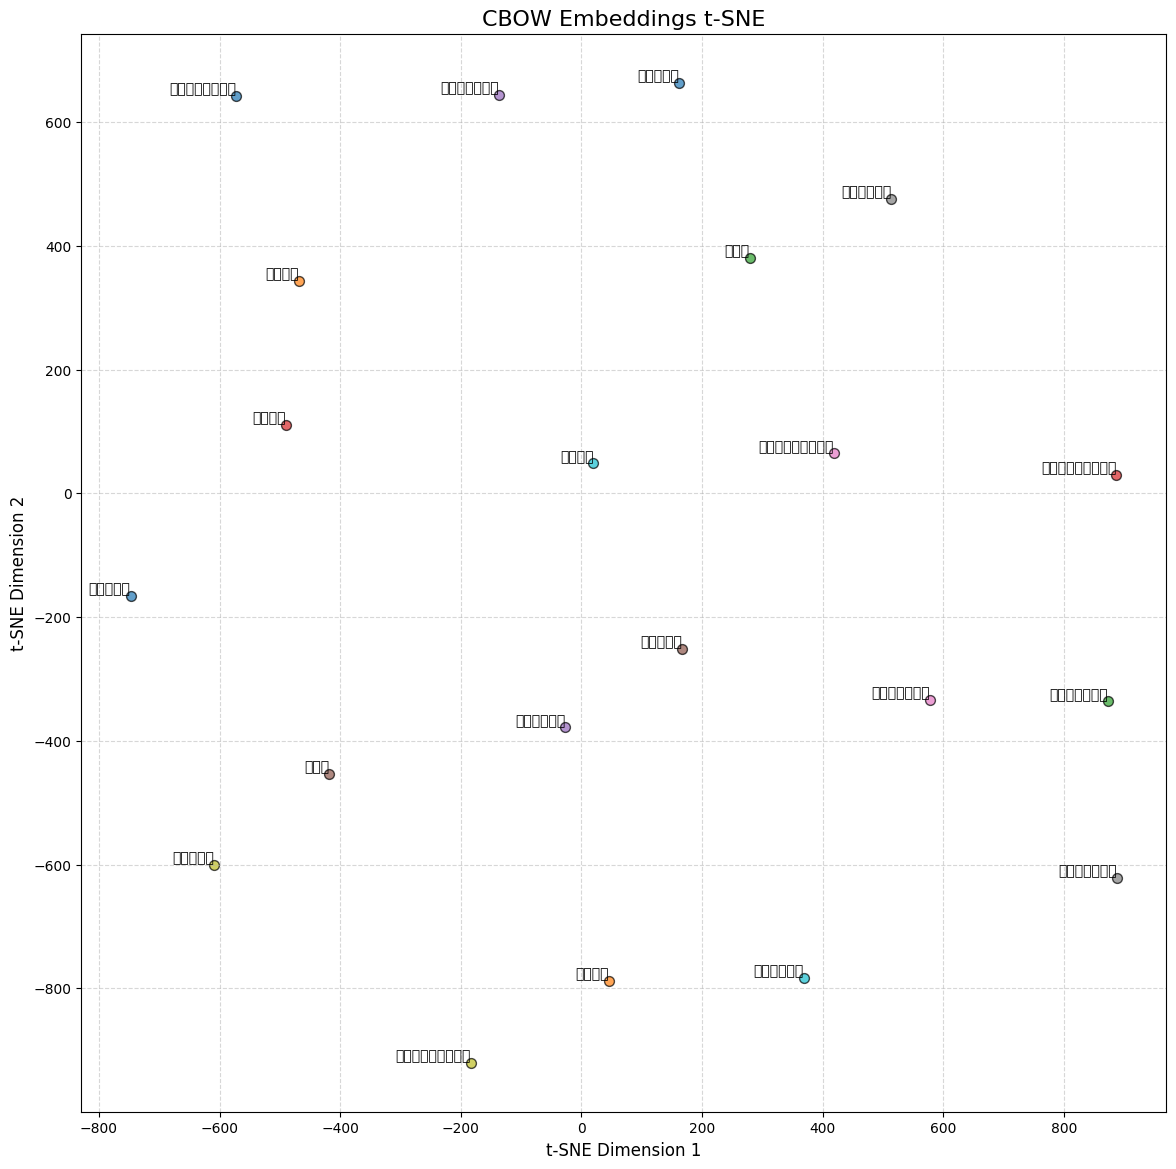

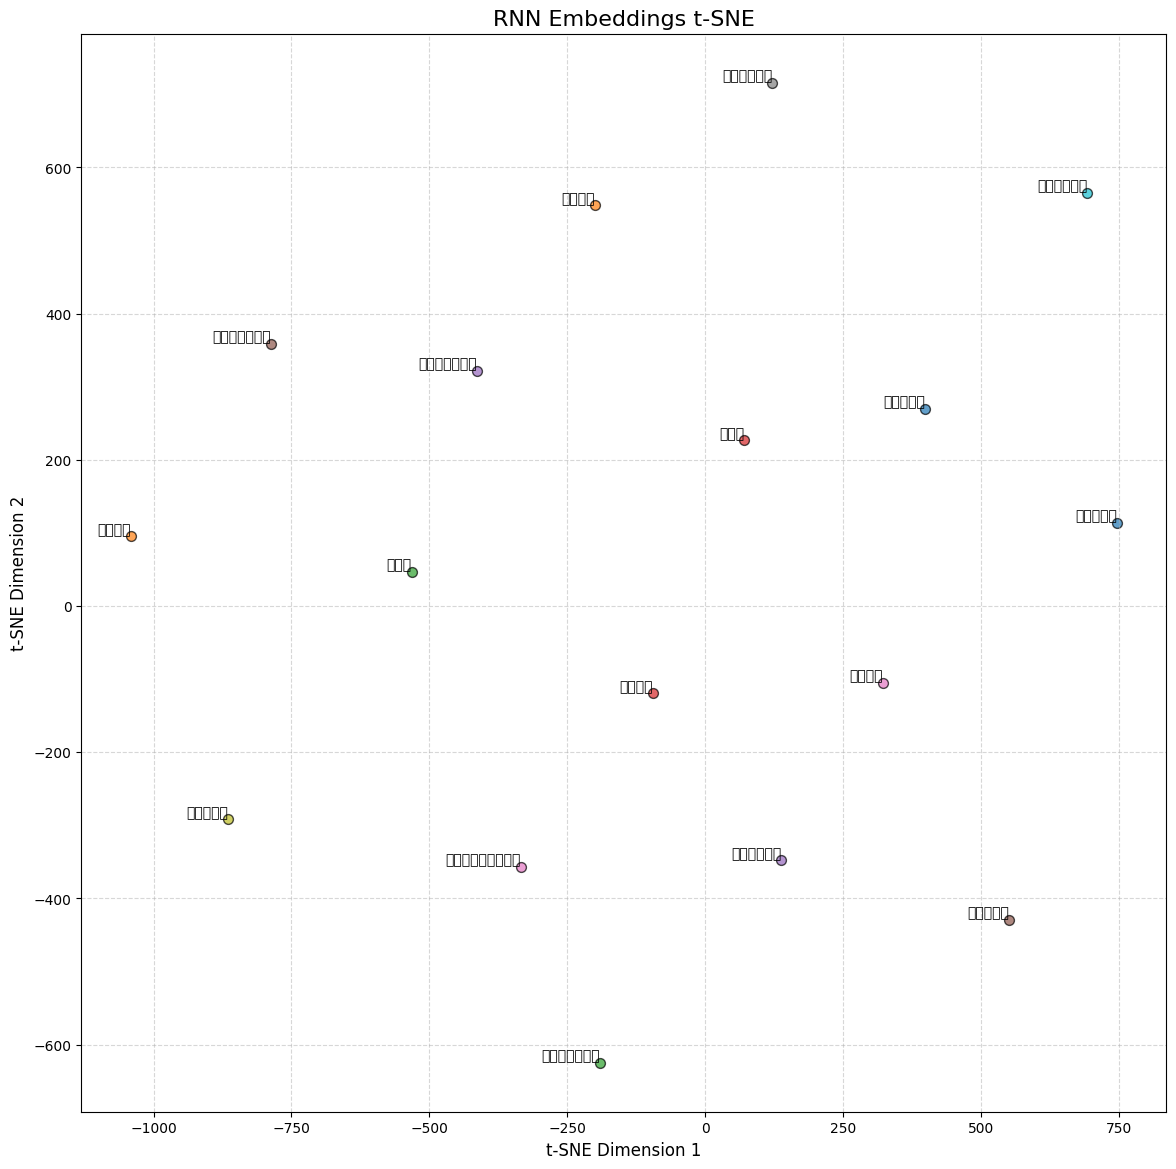

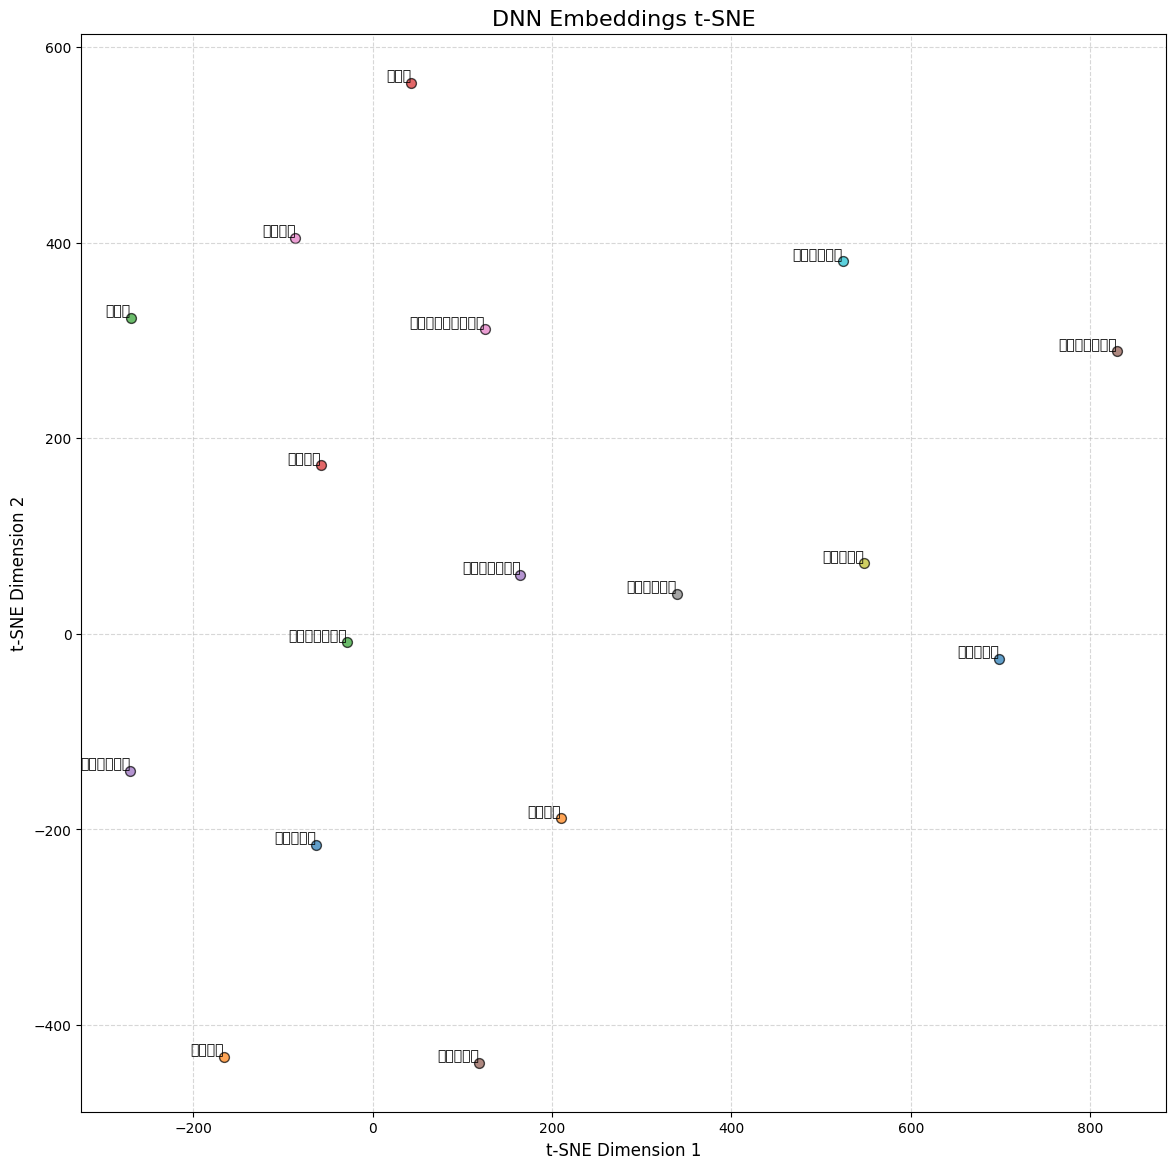

In [7]:
def plot_embeddings_tsne(embeddings, words, title, is_cbow=True, perplexity=30, learning_rate=200):
    """
    Plots word embeddings in 2D space using t-SNE with improved visualization.

    Parameters:
        embeddings (dict or np.ndarray): CBOW embeddings as dict or RNN embeddings as array.
        words (list of str): List of words to visualize.
        title (str): Title of the plot.
        is_cbow (bool): Flag indicating if embeddings are CBOW.
        perplexity (int): Perplexity value for t-SNE.
        learning_rate (int): Learning rate value for t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=learning_rate)
    
    # Extract vectors and valid words
    if is_cbow:
        valid_words = [word for word in words if word in embeddings]
        word_vectors = np.array([embeddings[word] for word in valid_words])
    else:
        valid_words = [word for word in words if word in word_to_index and word_to_index[word] < embeddings.shape[0]]
        word_vectors = np.array([embeddings[word_to_index[word]] for word in valid_words])
    
    # Apply t-SNE
    reduced_vectors = tsne.fit_transform(word_vectors)
    
    # Plot the results
    plt.figure(figsize=(14, 14))
    for i, word in enumerate(valid_words):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], s=50, alpha=0.7, edgecolors='k')
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=10, ha='right', va='bottom')
    
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.show()

words_to_visualize = [
    'அரசர்', 'அரசி', 'படை', 'போர்', 'மன்னர்',
    'சோழர்', 'பாண்டியர்', 'குதிரை', 'வீரன்', 'போராளி',
    'கேள்வி', 'பதில்', 'அழகு', 'அரசியல்',
    'தீர்மானம்', 'விவாதம்', 'கதை', 'பதினம்',
    'அரண்மனை', 'சிங்கம்', 'போராட்டம்', 'அரசு', 'அமைச்சர்'
]
print("=== t-SNE Visualization ===")
plot_embeddings_tsne(cbow_embeddings, words_to_visualize, "CBOW Embeddings t-SNE", is_cbow=True, perplexity=10, learning_rate=300)
plot_embeddings_tsne(rnn_embeddings, words_to_visualize, "RNN Embeddings t-SNE", is_cbow=False, perplexity=10, learning_rate=300)
plot_embeddings_tsne(dnn_embeddings, words_to_visualize, "DNN Embeddings t-SNE", is_cbow=False, perplexity=10, learning_rate=300)

### 3. Analogical Reasoning
we evaluate the embeddings' capability to solve word analogies. For example, if the relationship is "king is to queen as man is to woman," the model should correctly infer this relationship using the embeddings

In [8]:
# New Intrinsic Evaluation: Analogical Reasoning
def analogy_task(word_a, word_b, word_c, embeddings, is_cbow=True):
    """
    Solves analogy task: "word_a is to word_b as word_c is to ?"
    
    Parameters:
        word_a (str): First word in analogy
        word_b (str): Second word in analogy
        word_c (str): Third word in analogy
        embeddings (dict or np.ndarray): CBOW embeddings as dict or RNN embeddings as array
        is_cbow (bool): Flag indicating if embeddings are CBOW
    
    Returns:
        str: The word that completes the analogy
    """
    vector_a = get_vector(word_a, embeddings, is_cbow)
    vector_b = get_vector(word_b, embeddings, is_cbow)
    vector_c = get_vector(word_c, embeddings, is_cbow)
    
    analogy_vector = vector_b - vector_a + vector_c
    
    # Define vocabulary
    if is_cbow:
        vocabulary = embeddings.keys()
    else:
        vocabulary = word_to_index.keys()
    
    max_similarity = -1
    best_word = None
    for word in vocabulary:
        if word in [word_a, word_b, word_c]:
            continue
        vector_word = get_vector(word, embeddings, is_cbow)
        similarity = cosine_similarity([analogy_vector], [vector_word])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            best_word = word
    
    return best_word

# Analogies to test
analogies = [
    ('அரசர்', 'அரசி', 'மன்னர்'),  # King is to Queen as Emperor is to ?
    ('சோழர்', 'பாண்டியர்', 'குதிரை'),  # Chola is to Pandya as Horse is to ?
    ('அரண்மனை', 'அரசு', 'படை'),  # Palace is to Kingdom as Army is to ?
    #('அழகு', 'அரசியல்', 'விவாதம்'),  # Beauty is to Politics as Debate is to ?
    #('வீரன்', 'போராளி', 'புகழ்'),  # Warrior is to Fighter as Glory is to ?
    ('நதி', 'கடல்', 'அலை'),  # River is to Sea as Wave is to ?
    ('விழா', 'பண்டிகை', 'நடனம்'),  # Celebration is to Festival as Dance is to ?
    ('பேரரசு', 'அரண்மனை', 'தளபதி'),  # Emperor is to Palace as Commander is to ?
    #('காதல்', 'தவம்', 'அமைதி'),  # Love is to Meditation as Peace is to ?
    #('படை', 'போர்', 'சங்கம்'),  # Army is to War as Assembly is to ?
    ('மணி', 'மாலை', 'மலர்'),  # Gem is to Necklace as Flower is to ?
    #('பூமி', 'வானம்', 'சூரியன்')  # Earth is to Sky as Sun is to ?
]


print("=== Analogical Reasoning ===\n")
for word_a, word_b, word_c in analogies:
    cbow_answer = analogy_task(word_a, word_b, word_c, cbow_embeddings, is_cbow=True)
    rnn_answer = analogy_task(word_a, word_b, word_c, rnn_embeddings, is_cbow=False)
    dnn_answer = analogy_task(word_a, word_b, word_c, dnn_embeddings, is_cbow=False)
    print(f"{word_a} is to {word_b} as {word_c} is to ?")
    print(f"CBOW Answer: {cbow_answer}")
    print(f"RNN Answer: {rnn_answer}")
    print(f"DNN Answer: {dnn_answer}\n")

=== Analogical Reasoning ===

அரசர் is to அரசி as மன்னர் is to ?
CBOW Answer: ராணியின்
RNN Answer: “பொன்
DNN Answer: போகிறவர்களில்

சோழர் is to பாண்டியர் as குதிரை is to ?
CBOW Answer: செய்துகொண்டிருந்த
RNN Answer: குதிரைகள்
DNN Answer: கோவிலைச்

அரண்மனை is to அரசு as படை is to ?
CBOW Answer: காணவும்
RNN Answer: அவசியமும்
DNN Answer: நாயகரும்

நதி is to கடல் as அலை is to ?
CBOW Answer: நீரை
RNN Answer: கஜமுகன்
DNN Answer: கஷ்டத்தைத்

விழா is to பண்டிகை as நடனம் is to ?
CBOW Answer: அலுவல்களைப்
RNN Answer: இலட்சியம்
DNN Answer: உறையிலே

பேரரசு is to அரண்மனை as தளபதி is to ?
CBOW Answer: யோசித்தோம்
RNN Answer: மாடமாளிகைகளும்
DNN Answer: நள்ளிரவு

மணி is to மாலை as மலர் is to ?
CBOW Answer: வீசிற்று
RNN Answer: காததூரத்தில்
DNN Answer: ஆட்களில்



#### Observations

- **`CBOW Embeddings`**: The analogical reasoning results for CBOW embeddings often yield contextually disconnected terms. For example, in the analogy "அரசர் (King) is to அரசி (Queen) as மன்னர் (Emperor) is to ?", CBOW returns "ராணியின்" (of the Queen), which partially captures the association but lacks semantic relevance to the intended analogy. Similarly, in "சோழர் (Chola) is to பாண்டியர் (Pandya) as குதிரை (Horse) is to ?", CBOW’s response, "செய்துகொண்டிருந்த" (doing/ongoing), does not relate to the expected context.

- **`RNN Embeddings`**: The RNN embeddings demonstrate a more contextually aware understanding in some analogies. For instance, in "சோழர் (Chola) is to பாண்டியர் (Pandya) as குதிரை (Horse) is to ?", the RNN model returns "குதிரைகள்" (Horses), which aligns well with the expected association. Similarly, "மாடமாளிகைகளும்" (Mansions) for "பேரரசு (Emperor) is to அரண்மனை (Palace) as தளபதி (Commander) is to ?" captures a related concept of grandeur or authority, although it is not fully precise.

- **`DNN Embeddings`**: The DNN embeddings exhibit a stronger tendency toward broader associations but often return words with limited contextual relevance. For instance, in "அரண்மனை (Palace) is to அரசு (Kingdom) as படை (Army) is to ?", DNN’s answer "நாயகரும்" (Leaders) loosely relates but lacks the precision expected in analogical reasoning. In "நதி (River) is to கடல் (Sea) as அலை (Wave) is to ?", the answer "கஷ்டத்தைத்" (Difficulty) is contextually disconnected, indicating limitations in capturing specific relationships.

#### Summary

The analogical reasoning evaluation indicates that **RNN embeddings offer more contextually relevant answers** than CBOW or DNN embeddings, particularly in analogies that require a close association between concepts. While RNN embeddings occasionally lack precision, they generally produce responses that align better with the intended semantic structure of the analogy. 

## Extrinsic Evaluation 
### 1. Chatbot Response

We generate responses using both embeddings to evaluate how well they understand and generate contextually relevant words.
    

In [9]:
def chatbot_response_top_n(sentence, embeddings, is_cbow=True, top_n=3):
    words = sentence.split()
    sentence_vec = sentence_vector(words, embeddings, is_cbow)
    vocabulary = embeddings.keys() if is_cbow else word_to_index.keys()

    similarities = [
        (word, cosine_similarity([sentence_vec], [get_vector(word, embeddings, is_cbow)])[0][0])
        for word in vocabulary
    ]
    similarities.sort(key=lambda x: x[1], reverse=True)
    return [word for word, sim in similarities[:top_n]]

user_queries = [
    "அரசர் எங்கே?", "படைகள் எங்கே போகின்றன?", 
    "சோழர் மற்றும் பாண்டியர் பற்றி கூறு.", 
    "வீரன் போரில் எப்படி போராடினார்?", "அரசியலில் அவர்களின் பங்கு என்ன?"
]

print("=== Chatbot Responses Using CBOW Embeddings ===")
for query in user_queries:
    print(f"Query: {query}")
    print(f"Responses: {chatbot_response_top_n(query, cbow_embeddings, is_cbow=True)}\n")

print("=== Chatbot Responses Using RNN Embeddings ===")
for query in user_queries:
    print(f"Query: {query}")
    print(f"Responses: {chatbot_response_top_n(query, rnn_embeddings, is_cbow=False)}\n")

print("=== Chatbot Responses Using DNN Embeddings ===")
for query in user_queries:
    print(f"Query: {query}")
    print(f"Responses: {chatbot_response_top_n(query, dnn_embeddings, is_cbow=False)}\n")

=== Chatbot Responses Using CBOW Embeddings ===
Query: அரசர் எங்கே?
Responses: ['அரசர்', 'மந்திரக்காரி', 'விஷ்ணுதான்']

Query: படைகள் எங்கே போகின்றன?
Responses: ['எங்கே', 'படைகள்', 'வஜ்ராயுதத்தினால்']

Query: சோழர் மற்றும் பாண்டியர் பற்றி கூறு.
Responses: ['மற்றும்', 'பாண்டியர்', 'சோழர்']

Query: வீரன் போரில் எப்படி போராடினார்?
Responses: ['வீரன்', 'போரில்', 'எப்படி']

Query: அரசியலில் அவர்களின் பங்கு என்ன?
Responses: ['அவர்களின்', 'அடூத்தாற்போல்', 'போனேன்']

=== Chatbot Responses Using RNN Embeddings ===
Query: அரசர் எங்கே?
Responses: ['அரசர்', 'கொண்டிருக்கிறார்கள்', 'இல்லையா']

Query: படைகள் எங்கே போகின்றன?
Responses: ['எங்கே', 'படைகள்', 'வீதிகளும்']

Query: சோழர் மற்றும் பாண்டியர் பற்றி கூறு.
Responses: ['சோழர்', 'மற்றும்', 'பற்றி']

Query: வீரன் போரில் எப்படி போராடினார்?
Responses: ['போரில்', 'எப்படி', 'வீரன்']

Query: அரசியலில் அவர்களின் பங்கு என்ன?
Responses: ['அவர்களின்', 'மனத்தின்', 'இளம்பெண்ணை']

=== Chatbot Responses Using DNN Embeddings ===
Query: அரசர் எங்கே?
Responses: ['அ

#### Observations

- **`CBOW Embeddings`**: The responses generated by CBOW embeddings often contain words that lack contextual relevance to the query. For instance, in response to "அரசர் எங்கே?" (Where is the king?), words like "மந்திரக்காரி" (magician) and "விஷ்ணுதான்" (Vishnu) appear, which are unrelated to the king’s location or status. Similarly, in "படைகள் எங்கே போகின்றன?" (Where are the armies going?), the word "வஜ்ராயுதத்தினால்" (with Vajra weapon) is included, showing limited alignment with the query’s context.

- **`RNN Embeddings`**: The RNN embeddings generate responses that are more contextually relevant, even though they are not always directly answering the queries. For example, in "அரசர் எங்கே?", RNN includes terms like "கொண்டிருக்கிறார்கள்" (they are), suggesting presence, albeit vaguely. In "படைகள் எங்கே போகின்றன?", the term "வீதிகளும்" (streets) aligns better with the question of direction or movement, reflecting the RNN's ability to capture relevant narrative terms.

- **`DNN Embeddings`**: The DNN embeddings display responses that incorporate broader associations but often lack direct relevance to the query. For example, in "அரசர் எங்கே?", words like "சந்ததிகளே" (descendants) and "முறையாகப்" (properly) appear, which only partially relate to the intended context. In the query "சோழர் மற்றும் பாண்டியர் பற்றி கூறு." (Tell me about the Cholas and Pandyas), DNN responses include terms like "வந்தும்" (came) and "கடைக்குட்டி" (small child), which lack precision in addressing the query’s focus.

#### Summary

The chatbot responses indicate that **RNN embeddings produce the most contextually aligned responses** for narrative-based queries in the Ponniyin Selvan text. RNN embeddings demonstrate a better grasp of the underlying context compared to CBOW and DNN, even though they may not directly answer every query. While DNN embeddings capture a wider semantic scope, their responses often lack the specific contextual alignment observed in RNN outputs.

### 2. Clustering

We perform clustering on selected words and calculate the silhouette score to evaluate the quality of clusters.
    

In [10]:
def clustering_evaluation(embeddings, words, is_cbow=True, n_clusters=5):
    valid_words = [word for word in words if (word in embeddings if is_cbow else word in word_to_index)]
    word_vectors = np.array([get_vector(word, embeddings, is_cbow) for word in valid_words])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(word_vectors)
    silhouette_avg = silhouette_score(word_vectors, labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    return silhouette_avg

words_for_clustering = [
    'அரசர்', 'அரசி', 'படை', 'போர்', 'மன்னர்',
    'சோழர்', 'பாண்டியர்', 'குதிரை', 'வீரன்', 'போராளி',
    'கேள்வி', 'பதில்', 'அழகு', 'அரசியல்',
    'தீர்மானம்', 'விவாதம்', 'கதை', 'பதினம்',
    'அரண்மனை', 'சிங்கம்', 'போராட்டம்', 'அரசு', 'அமைச்சர்'
]
print("=== Clustering Evaluation ===")
silhouette_cbow = clustering_evaluation(cbow_embeddings, words_for_clustering, is_cbow=True)
silhouette_rnn = clustering_evaluation(rnn_embeddings, words_for_clustering, is_cbow=False)
silhouette_rnn = clustering_evaluation(dnn_embeddings, words_for_clustering, is_cbow=False)

=== Clustering Evaluation ===
Silhouette Score: 0.0241
Silhouette Score: 0.0341
Silhouette Score: 0.0488


#### Clustering Evaluation

- **`CBOW Embeddings`**: The CBOW embeddings achieved a low silhouette score of 0.0241. This suggests that the embeddings did not group words into coherent clusters, with significant overlap between clusters. The low score reflects CBOW’s limitations in capturing the nuanced semantic relationships in the Ponniyin Selvan text.

- **`RNN Embeddings`**: The RNN embeddings slightly improved upon the CBOW with a silhouette score of 0.0341. While still modest, this score suggests the RNN embeddings captured some thematic or contextual similarity between words. This slight improvement aligns with the RNN's ability to learn sequential context, aiding in grouping semantically related terms, although the overall clustering quality remains weak.

- **`DNN Embeddings`**: The DNN embeddings displayed the highest silhouette score among the three models at 0.0488. Although this score is still low, it suggests that DNN embeddings may capture broader groupings or thematic associations to some extent. However, the clustering quality remains limited and does not distinctly separate semantic clusters.

#### Summary

The clustering evaluation shows that **DNN embeddings perform slightly better in clustering**, with the highest silhouette score.

### 3. Contextual Sentence Similarity

We calculate the similarity between pairs of contextual sentences to see how well each embedding captures sentence meaning.
    

In [11]:
contextual_sentence_pairs = [
    (
        ['அரசர்', 'புதிய', 'கட்சி', 'நிறுவினார்'],  # The king established a new faction
        ['மன்னர்', 'புதிய', 'அரசு', 'நிறுவினார்']    # The emperor established a new government
    ),
    (
        ['சோழர்', 'போராட்டம்', 'நடத்தியார்'],          # The Cholas conducted the war
        ['பாண்டியர்', 'போர்', 'நடத்தியார்கள்']          # The Pandyas conducted the battle
    )
]

print("=== Contextual Sentence Similarity ===")
for idx, (sent1, sent2) in enumerate(contextual_sentence_pairs):
    sim_cbow = cosine_similarity(
        [sentence_vector(sent1, cbow_embeddings, is_cbow=True)],
        [sentence_vector(sent2, cbow_embeddings, is_cbow=True)]
    )[0][0]
    sim_rnn = cosine_similarity(
        [sentence_vector(sent1, rnn_embeddings, is_cbow=False)],
        [sentence_vector(sent2, rnn_embeddings, is_cbow=False)]
    )[0][0]
    sim_dnn = cosine_similarity(
        [sentence_vector(sent1, dnn_embeddings, is_cbow=False)],
        [sentence_vector(sent2, dnn_embeddings, is_cbow=False)]
    )[0][0]
    print(f"Pair {idx + 1}: CBOW Similarity: {sim_cbow:.4f}, RNN Similarity: {sim_rnn:.4f}, DNN Similarity: {sim_dnn:.4f}")

=== Contextual Sentence Similarity ===
Pair 1: CBOW Similarity: 0.3456, RNN Similarity: 0.5182, DNN Similarity: 0.5156
Pair 2: CBOW Similarity: 0.0852, RNN Similarity: 0.0593, DNN Similarity: -0.0042


### Contextual Sentence Similarity Evaluation

- **`Pair 1 (The king established a new faction vs. The emperor established a new government)`**:
  - **CBOW Embeddings**: Achieved a similarity score of 0.3456. CBOW captures some basic contextual overlap between these sentences, but the score indicates only a moderate level of semantic alignment.
  - **RNN Embeddings**: Scored 0.5182, indicating a higher contextual similarity. The RNN model effectively captures the parallel structure and meaning of the sentences, aligning well with the shared theme of establishment.
  - **DNN Embeddings**: Close to the RNN score at 0.5156, DNN also reflects a strong contextual similarity.
  
- **`Pair 2 (The Cholas conducted the war vs. The Pandyas conducted the battle)`**:
  - **CBOW Embeddings**: Scored 0.0852, showing limited similarity between the sentences. CBOW struggles to capture the theme of conflict present in both sentences, yielding a low contextual alignment.
  - **RNN Embeddings**: Achieved a similarity score of 0.0593. The RNN model, while generally good with context, does not capture the war-related similarity in this case, suggesting limitations with less explicit parallel structure.
  - **DNN Embeddings**: Registered a negative similarity score of -0.0042, indicating a lack of alignment. This score suggests that DNN embeddings struggled to recognize thematic parallels between these sentences.

#### Summary

The contextual sentence similarity results highlight that **RNN embeddings generally perform better in capturing sentence-level context**, as shown in Pair 1. The sequential learning nature of RNN embeddings allows for better handling of sentences with explicit parallels. However, both RNN and DNN embeddings have limitations with more nuanced or implicit thematic connections, as seen in Pair 2.